# Task 1: Linear Triangulation [15]

**Please go through the notebook once before beginning working on it!**

The goal of this section is to understand the geometric relationships between multiple views of a scene. Linear triangulation is a fundamental step in 3D reconstruction pipelines. It involves estimating the 3D coordinates of points in a scene using projections onto two or more images taken from different camera perspectives. This process is essential because it allows us to map the 2D image features into the 3D world, providing a foundation for building more detailed 3D models.

In this notebook you will:
1. Pre-process the dataset and extract key features from the images using feature detection methods such as **SIFT** or **ORB**.
2. Match these features across image pairs to identify corresponding points.
3. Compute the fundamental and essential matrices to estimate the relative poses of the cameras.
4. Use linear triangulation to determine the 3D coordinates of a point in space and visualize it.

<span style="color: red">**Submission Guidelines:**</span> Only one member of each group has to submit the file on LMS. The name of the file should be your group number. For example, if you are Group 1 then the file name should be **G01_Deliverable1.ipynb**. If you are unsure about your group number, then you can confirm it in the [sheet](https://docs.google.com/spreadsheets/d/1vN6JOLDWoFR5BnXTr0lMYGv_e9VzyAbqSUqf4VdjCQI/edit?gid=0#gid=0) 

#### Imports

In [39]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import struct
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# add imports here

### Dataset
We will use the [Heritage-Recon](https://drive.google.com/drive/folders/1eZvmk4GQkrRKUNZpagZEIY_z8Lsdw94v) dataset, which contains sets of images of various landmarks captured from multiple angles. You can choose one landmark for your project and use its dataset for this task.

If you go through the dataset, you will find the images for your landmark in the **dense/images** folder. There are also some other important files that you will see. For example, the root directory of the brandenburg gate dataset contains the **brandenburg_gate.ply**, which is the actual 3D model generated from the dataset. You will generating something similar for the next deliverable as well.

The **neuralsfm** folder contains three key **.bin** files, which are binary files commonly used in Structure from Motion (SfM) pipelines like COLMAP for storing 3D reconstruction data:
1. cameras.bin: stores information about the cameras used in the SfM process. It includes intrinsic parameters, such as focal lengths and principal points, as well as extrinsic parameters that define the camera's position and orientation.
2. images.bin: contains the images’ pose information within the 3D space. It also includes 2D keypoints detected in each image and their associations with 3D points. This file is crucial for understanding where each image is located in the reconstructed scene.
3. points3D.bin: holds information about the reconstructed 3D points, including their 3D coordinates, color, and visibility across images. It essentially represents the sparse point cloud of the scene, where each point correlates with specific 2D keypoints in the images.

The **semantic_maps** folder contains .npz files that store semantic segmentation data in a compressed format. Each .npz file corresponds to a semantic map or segmentation mask for a particular image, with classes or labels encoded as numerical values.

### Loading in our data

Load in 3 different images from the images folder and display them.

In [11]:
# Path to the dataset (update with the actual path)
images_path = "../brandenburg_gate/brandenburg_gate/dense/images"

# List all files in the directory
image_files = sorted(os.listdir(images_path))

# Helper function to check if a file is an image
def is_image_file(filename):
    valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

# Filter to get only valid image files (skipping the first two files)
valid_image_files = [file for file in image_files[2:] if is_image_file(file)]

In [12]:
# Select three random images
random_images = random.sample(valid_image_files, 3)

# Load the selected images
image1 = cv2.imread(os.path.join(images_path, random_images[0]))
image2 = cv2.imread(os.path.join(images_path, random_images[1]))
image3 = cv2.imread(os.path.join(images_path, random_images[2]))

# Convert BGR to RGB for displaying
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3_rgb = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)


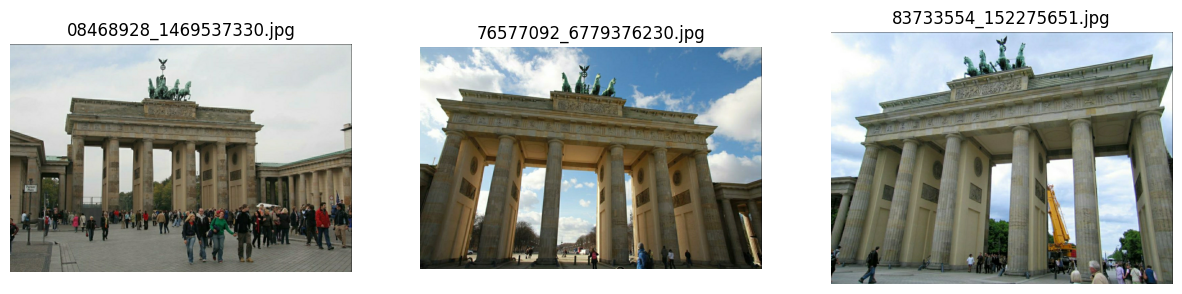

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image1_rgb)
plt.title(random_images[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image2_rgb)
plt.title(random_images[1])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image3_rgb)
plt.title(random_images[2])
plt.axis('off')

plt.show()

#### Pre-processing

If you go through the images in the dataset you will notice images with varying dimensions, angles, brightness levels etc. For us to effectively use our dataset, we first need to pre-process our images. Pre-processing ensures that the images are prepared consistently for feature detection, matching, and camera pose estimation.

Some helper functions that might be useful.

In [20]:
def get_img_paths(folder_pth):
    """Returns a list containing filenames of all jpg files in folder_pth"""
    jpg_files = []

    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            # uncomment the line below if you want to include the entire path in the filename
            filename = os.path.join(folder_pth, filename)
            jpg_files.append(filename)

    return jpg_files


def load_images(folder_pth):
    """Loads all images in folder_path"""
    images = []
    for filename in os.listdir(folder_pth):
        if filename.lower().endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_pth, filename))
            images.append(img)

    return images


def resize_image(img, size=(800, 600)):
    """Resizes image to a specified size."""
    return cv2.resize(img, size)


def convert_to_grayscale(img):
    """Converts an image to grayscale."""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# you can add other functions here as well.
# Additional preprocessing function for normalization
def normalize_brightness(img):
    """Normalizes the brightness of an image using histogram equalization."""
    if len(img.shape) == 2:  # Grayscale
        return cv2.equalizeHist(img)
    elif len(img.shape) == 3:  # Color
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    
# Preprocessing pipeline
def preprocess_images(folder_pth, resize_dim=(800, 600)):
    """Loads, preprocesses, and returns images."""
    img_paths = get_img_paths(folder_pth)
    preprocessed_images = []
    for path in img_paths:
        img = cv2.imread(path)
        if img is not None:
            img = resize_image(img, size=resize_dim)  # Resize
            img = convert_to_grayscale(img)  # Convert to grayscale
            img = normalize_brightness(img)  # Normalize brightness
            preprocessed_images.append(img)
    return preprocessed_images

Now, load the images from the dataset folder, apply the pre-processing steps, and display few of the pre-processed images to verify. I have included a few types of pre-processing methods above, but you can use any other method as well that you believe might be helpful. Give a two-liner explaination for your pre-processing choices.

**Ans:** 
1) Resizing: Ensures consistent dimensions for all images, simplifying feature extraction and matching across varying image sizes.
2) Grayscale Conversion: Reduces complexity by using one channel instead of three, while retaining key structural information needed for feature detection.
3) Brightness Normalization: Compensates for lighting variations, ensuring robust and consistent feature detection across differently lit images.

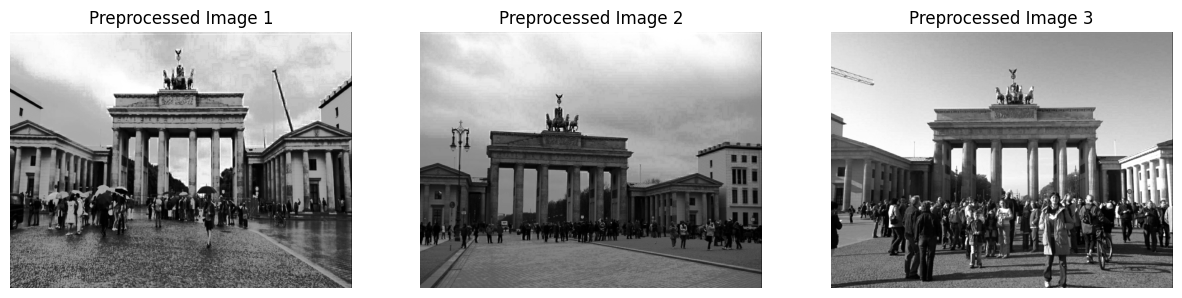

In [21]:
preprocessed_images = preprocess_images(images_path)


plt.figure(figsize=(15, 5))
for i, img in enumerate(preprocessed_images[:3]):  
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Preprocessed Image {i + 1}")
    plt.axis('off')
plt.show()

### Feature Detection

The goal is to identify distinct and robust points in the images that can be matched across different views. These feature points are the key to establishing correspondences between images.

There are several feature detection algorithms such as SIFT, SURF, or ORB available in the cv2 library. When using any of the algorithms, be sure to check the format of the image that it accepts.

Using any feature detection algorithm, extract the features from two images and display the images with the features higlighted on them. Here is an example:

<img src="assets/feature_detection.png" alt="My Image" width="800"/>

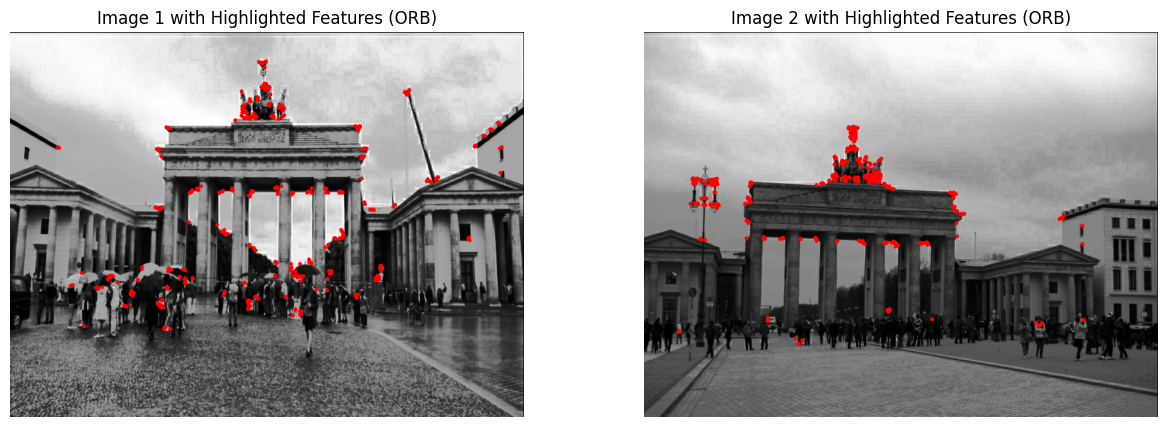

In [33]:
# Select two preprocessed images from the previously loaded images
image1 = preprocessed_images[0]
image2 = preprocessed_images[1]

# Initialize the ORB detector
orb = cv2.ORB_create()

# Detect features and compute descriptors
keypoints1_orb, descriptors1_orb = orb.detectAndCompute(image1, None)
keypoints2_orb, descriptors2_orb = orb.detectAndCompute(image2, None)

# Convert grayscale images to BGR format for color overlay
image1_color = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
image2_color = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)

# Highlight keypoints by drawing small red circles
for kp in keypoints1_orb:
    x, y = int(kp.pt[0]), int(kp.pt[1])  # Get x, y coordinates
    cv2.circle(image1_color, (x, y), radius=3, color=(0, 0, 255), thickness=-1)  # Red circles

for kp in keypoints2_orb:
    x, y = int(kp.pt[0]), int(kp.pt[1])
    cv2.circle(image2_color, (x, y), radius=3, color=(0, 0, 255), thickness=-1)  # Red circles

# Display the images with highlighted features
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1_color, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.title("Image 1 with Highlighted Features (ORB)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2_color, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.title("Image 2 with Highlighted Features (ORB)")
plt.axis('off')

plt.show()

### Feature Matching

Feature matching is a crucial step in 3D reconstruction because it helps find corresponding points between different images. Once you've detected the keypoints and descriptors using a feature detector, the next step is to match these descriptors across pairs of images.


Use the keypoints and descriptors extracted above for the two images and match the features across the two images. You can use this as a reference image:

<img src="assets/feature_matching.png" alt="My Image" width="800"/>

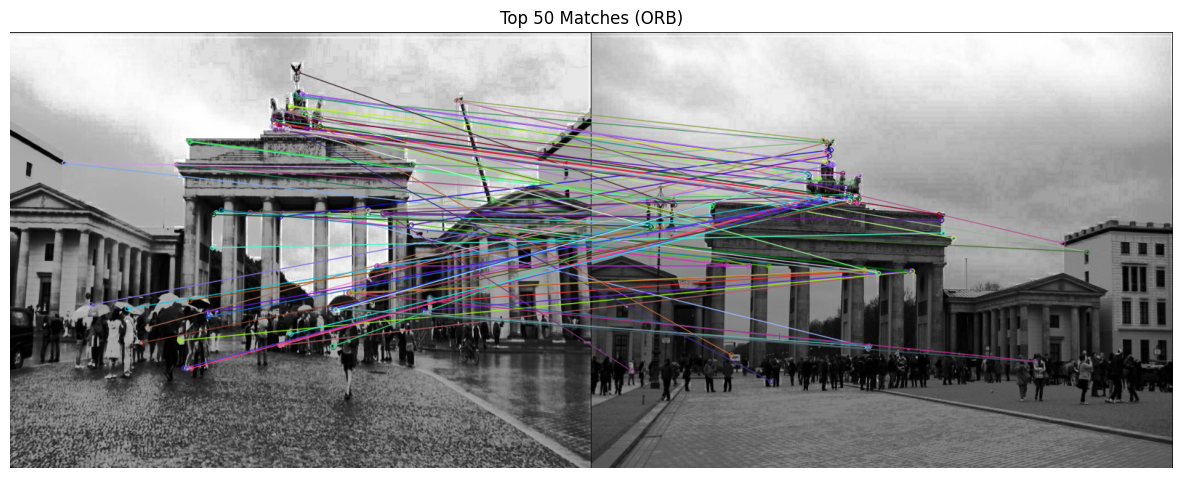

In [34]:
# Match features for ORB
def match_features_orb(descriptors1, descriptors2, cross_check=True):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=cross_check)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

orb_matches = match_features_orb(descriptors1_orb, descriptors2_orb)

# Draw the top 50 matches for ORB
orb_matched_image = cv2.drawMatches(
    image1, keypoints1_orb, image2, keypoints2_orb, orb_matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Display matches
plt.figure(figsize=(15, 10))
plt.imshow(orb_matched_image)
plt.title("Top 50 Matches (ORB)")
plt.axis('off')
plt.show()

### Camera Pose Estimation

Camera pose estimation involves determining the relative position and orientation (i.e., rotation and translation) of the camera between two views. This is typically done by estimating the essential matrix or fundamental matrix between two sets of matched keypoints, and then decomposing these matrices to recover the camera pose.

So essentially:
1. Find the **fundamental matrix (F)** using the matched keypoints.
2. Decompose the **essential matrix (E)** into the rotation and translation components.
3. Use epipolar geometry to verify or refine the solution.

You can use the lecture slides as reference for computing these. 

Calculate the fundemental and essential matrices. Use these to recover the translation and rotation matrices.

In [37]:
# Load the camera intrinsics from the cameras.bin file
def read_cameras_bin(file_path):
    cameras = {}
    with open(file_path, 'rb') as f:
        num_cameras = struct.unpack('<Q', f.read(8))[0]
        for _ in range(num_cameras):
            camera_id = struct.unpack('<I', f.read(4))[0]
            model = struct.unpack('<i', f.read(4))[0]
            width = struct.unpack('<Q', f.read(8))[0]
            height = struct.unpack('<Q', f.read(8))[0]
            params = struct.unpack('<4d', f.read(32))  # Assuming 4 parameters (fx, fy, cx, cy)
            cameras[camera_id] = {
                'model': model,
                'width': width,
                'height': height,
                'params': params
            }
    return cameras

# Load camera intrinsics
cameras = read_cameras_bin("../brandenburg_gate/brandenburg_gate/neuralsfm/cameras.bin")
intrinsic_params = list(cameras.values())[0]['params']  # Extract the first camera's parameters
fx, fy, cx, cy = intrinsic_params

# Construct the intrinsic matrix
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0,  0,  1]])

# Extract the coordinates of the matched keypoints
def extract_matched_points(matches, keypoints1, keypoints2):
    pts1 = []
    pts2 = []
    for match in matches:
        pts1.append(keypoints1[match.queryIdx].pt)
        pts2.append(keypoints2[match.trainIdx].pt)
    return np.array(pts1, dtype=np.float32), np.array(pts2, dtype=np.float32)

# Use the ORB matches to extract points
pts1, pts2 = extract_matched_points(orb_matches, keypoints1_orb, keypoints2_orb)

# Compute the fundamental matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC, ransacReprojThreshold=1.0)

# Filter inlier points using the mask
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

# Compute the essential matrix
E = K.T @ F @ K

# Decompose the essential matrix to find rotation (R) and translation (T)
_, R, T, _ = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

# Print the Rotation and Translation matrices
print("Rotation Matrix R:\n", R)
print()
print("Translation Vector T:\n", T)

Rotation Matrix R:
 [[-0.50335784  0.83964818 -0.20401424]
 [ 0.47523792  0.46620526  0.74619138]
 [ 0.72165075  0.27864598 -0.63370073]]

Translation Vector T:
 [[ 0.04242472]
 [-0.60986863]
 [ 0.79136616]]


### Linear Triangulation

Linear triangulation involves determining the 3D coordinates of a point in space based on its projections in two or more images taken from different viewpoints. Given two camera poses and the corresponding 2D feature points in both images, linear triangulation allows you to estimate the 3D coordinates of the points in the scene.

Compute the 3D coordinates of the matched feature points by solving the system of equations derived from the camera projection equations above.

In [38]:
# Compute the projection matrices for the two camera views
def compute_projection_matrix(K, R, t):
    """Compute the camera projection matrix P = K[R | t]."""
    Rt = np.hstack((R, t))  # Combine R and t
    P = K @ Rt  # Projection matrix
    return P

# Camera 1 (reference camera) projection matrix
P1 = compute_projection_matrix(K, np.eye(3), np.zeros((3, 1)))  # [I | 0]

# Camera 2 (target camera) projection matrix
P2 = compute_projection_matrix(K, R, T)

# Use inlier points for triangulation
pts1_inliers_h = cv2.convertPointsToHomogeneous(pts1_inliers).reshape(-1, 3).T
pts2_inliers_h = cv2.convertPointsToHomogeneous(pts2_inliers).reshape(-1, 3).T

# Perform linear triangulation using OpenCV's triangulatePoints
points_4D_h = cv2.triangulatePoints(P1, P2, pts1_inliers.T, pts2_inliers.T)

# Convert from homogeneous to 3D coordinates
points_3D = points_4D_h[:3] / points_4D_h[3]

# Print the 3D points
print("3D Points:\n", points_3D.T)

3D Points:
 [[-0.12421558 -0.05893591  0.8378739 ]
 [-0.08643323 -0.0685575   0.78186   ]
 [-0.12410473 -0.05868731  0.8380349 ]
 [-0.08536231 -0.06767308  0.78129286]
 [-0.09926046 -0.0653885   0.796024  ]
 [-0.11949176 -0.06075851  0.8312838 ]
 [-0.10109685 -0.06611242  0.8045639 ]
 [-0.24493167  0.05022058  0.94470036]
 [-0.08472192 -0.0675825   0.7803757 ]
 [-0.09165131 -0.05201009  0.80472696]
 [-0.05201858  0.03893352  0.808424  ]
 [-0.11858896 -0.0573787   0.8335936 ]
 [-0.2802523  -0.02345003  1.0027453 ]
 [-0.24312878  0.02666871  0.95138586]]


Visualise the 3D points obtained above. The results will probably not make any sense atm since we are only using two images, but this will help us in Task 2.

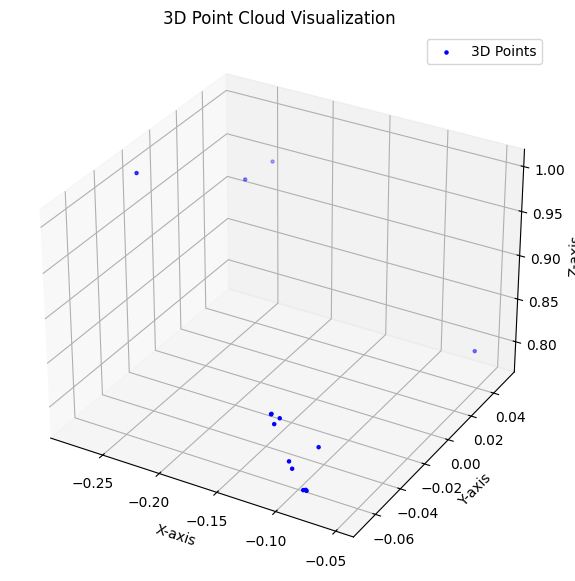

In [40]:
# Visualize the 3D points
def plot_3D_points(points_3D):
    """Plots the 3D points."""
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract X, Y, Z coordinates
    X = points_3D[0]
    Y = points_3D[1]
    Z = points_3D[2]
    
    # Scatter plot
    ax.scatter(X, Y, Z, c='blue', s=5, label='3D Points')

    # Labels and legend
    ax.set_title("3D Point Cloud Visualization")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.legend()
    plt.show()

plot_3D_points(points_3D)